# Example of extracting representation model digest

This example is based on the readthedocs example for schnetpack library.

In [1]:
import os
import schnetpack as spk
from schnetpack.datasets import QM9
import schnetpack.transform as trn

import torch
import torchmetrics
import pytorch_lightning as pl

qm9tut = './qm9tut'
if not os.path.exists('qm9tut'):
    os.makedirs(qm9tut)


In [2]:
# %rm split.npz

DB_PATH = "./qm9.db"
PROPERTY = QM9.Cv
BATCH_SIZE = 16
NUM_TRAIN = 110000
NUM_VALIDATION = 10000
CUTOFF = 5.
N_ATOM_BASIS = 32
T = 3
EPOCHS = 3
LR = 1e-4
NUM_WORKERS = 1
PIN_MEMORY = True

In [3]:
qm9data = QM9(
    DB_PATH,
    batch_size=BATCH_SIZE,
    num_train=NUM_TRAIN,
    num_val=NUM_VALIDATION,
    transforms=[
        trn.ASENeighborList(cutoff=float(CUTOFF)),
        trn.RemoveOffsets(PROPERTY, remove_mean=True, remove_atomrefs=True),
        trn.CastTo32()
    ],
    num_workers=NUM_WORKERS,
    split_file=os.path.join(qm9tut, "split.npz"),
    pin_memory=PIN_MEMORY, # set to false, when not using a GPU
    load_properties=[PROPERTY], #only load U0 property
)
qm9data.prepare_data()
qm9data.setup()

  0%|          | 0/6875 [00:00<?, ?it/s]

100%|██████████| 6875/6875 [01:07<00:00, 102.55it/s]


In [14]:
pairwise_distance = spk.atomistic.PairwiseDistances() # calculates pairwise distances between atoms
radial_basis = spk.nn.GaussianRBF(n_rbf=20, cutoff=CUTOFF)
schnet = spk.representation.SchNet(
    n_atom_basis=N_ATOM_BASIS, n_interactions=T,
    radial_basis=radial_basis,
    cutoff_fn=spk.nn.CosineCutoff(CUTOFF)
)
pred_property = spk.atomistic.Atomwise(n_in=N_ATOM_BASIS, output_key=PROPERTY)

nnpot = spk.model.NeuralNetworkPotential(
    representation=schnet,
    input_modules=[pairwise_distance],
    output_modules=[pred_property],
    postprocessors=[trn.CastTo64(), trn.AddOffsets(PROPERTY, add_mean=True, add_atomrefs=True)]
)

In [15]:
output_property = spk.task.ModelOutput(
    name=PROPERTY,
    loss_fn=torch.nn.MSELoss(),
    loss_weight=1.,
    metrics={
        "MAE": torchmetrics.MeanAbsoluteError()
    }
)

In [16]:
task = spk.task.AtomisticTask(
    model=nnpot,
    outputs=[output_property],
    optimizer_cls=torch.optim.AdamW,
    optimizer_args={"lr": LR}
)

/home/aimas/dtu/dl/DeepLearningProject/.venv/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


## Model training

Train a model with a few epochs, if you don't have a trained model already.

In [17]:
logger = pl.loggers.TensorBoardLogger(save_dir=qm9tut)
callbacks = [
    spk.train.ModelCheckpoint(
        model_path=os.path.join(qm9tut, "best_inference_model"),
        save_top_k=1,
        monitor="val_loss"
    )
]

trainer = pl.Trainer(
    callbacks=callbacks,
    logger=logger,
    default_root_dir=qm9tut,
    max_epochs=EPOCHS, # for testing, we restrict the number of epochs
)
trainer.fit(task, datamodule=qm9data)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                   | Params
---------------------------------------------------
0 | model   | NeuralNetworkPotential | 18.3 K
1 | outputs | ModuleList             | 0     
---------------------------------------------------
18.3 K    Trainable params
0         Non-trainable params
18.3 K    Total params
0.073     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/aimas/dtu/dl/DeepLearningProject/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


/home/aimas/dtu/dl/DeepLearningProject/.venv/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 16. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/home/aimas/dtu/dl/DeepLearningProject/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 2: 100%|██████████| 6875/6875 [09:19<00:00, 12.29it/s, v_num=1, val_loss=0.120]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 6875/6875 [09:19<00:00, 12.28it/s, v_num=1, val_loss=0.120]


## Extracting digest

The following code extracts the representation vector digest, following a forward pass of the model. This is done using Pytorch hooks via the `register_forward_hook`-method. 
First, we make a plot to get an overview of the model layers and their name references.


In [4]:
import torch

trained_model = torch.load(os.path.join(qm9tut, 'best_inference_model'))

for name, param in trained_model.state_dict().items():
    print(name, param.shape)


postprocessors.1.atomref torch.Size([100])
postprocessors.1.mean torch.Size([])
representation.radial_basis.widths torch.Size([20])
representation.radial_basis.offsets torch.Size([20])
representation.cutoff_fn.cutoff torch.Size([1])
representation.embedding.weight torch.Size([100, 32])
representation.interactions.0.in2f.weight torch.Size([32, 32])
representation.interactions.0.f2out.0.weight torch.Size([32, 32])
representation.interactions.0.f2out.0.bias torch.Size([32])
representation.interactions.0.f2out.1.weight torch.Size([32, 32])
representation.interactions.0.f2out.1.bias torch.Size([32])
representation.interactions.0.filter_network.0.weight torch.Size([32, 20])
representation.interactions.0.filter_network.0.bias torch.Size([32])
representation.interactions.0.filter_network.1.weight torch.Size([32, 32])
representation.interactions.0.filter_network.1.bias torch.Size([32])
representation.interactions.1.in2f.weight torch.Size([32, 32])
representation.interactions.1.f2out.0.weight to

Next, we define a callback function that will be called by the hook. This function will be called with the following arguments:
- `module`: the layer that the hook is attached to
- `input`: the input digest to the layer
- `output`: the output digest of the layer

The function implemented below will take the input digest for the first property inference layer and append the digest Pytorch tensor to a static list `digest_inf_input`. 

**NOTE: Adding a hook to the output of the last representation layer should provide the same digest as for the input of the inference layer. Somehow they are not the same. By convention, we use a hook for the input of the infernece layer** 

In [5]:
import numpy as np
from ase import Atoms

digests_rep_output = []
digest_inf_input = []
converter = spk.interfaces.AtomsConverter(neighbor_list=trn.ASENeighborList(cutoff=float(CUTOFF)), 
                                          dtype=torch.float32,
                                          device='cuda')

def forward_hook_out_callback(module, input, output):
    digests_rep_output.append(output)

def forward_hook_in_callback(module, input, output):
    digest_inf_input.append(input)

# model_layer = trained_model.representation.interactions[2].f2out[1]
model_layer_inf_input = trained_model.output_modules[0].outnet[0]
# hook_handle = model_layer.register_forward_hook(forward_hook_out_callback)
hook_handle_inf_input = model_layer_inf_input.register_forward_hook(forward_hook_in_callback)

trained_model.eval()

numbers = np.array([6, 1, 1, 1, 1])
positions = np.array([[-0.0126981359, 1.0858041578, 0.0080009958],
                      [0.002150416, -0.0060313176, 0.0019761204],
                      [1.0117308433, 1.4637511618, 0.0002765748],
                      [-0.540815069, 1.4475266138, -0.8766437152],
                      [-0.5238136345, 1.4379326443, 0.9063972942]])
atoms = Atoms(numbers=numbers, positions=positions)
inputs = converter(atoms)

pred = trained_model(inputs)

print(f"Number of digests captured by forward pass hook: {len(digests_rep_output)}")
print(f"Number of digests captured by forward pass hook input: {len(digest_inf_input)}")

for d in digest_inf_input:
    print(d[0])
    print(d[0].shape)

for d in digests_rep_output:
    print(d)
    break

# hook_handle.remove()
hook_handle_inf_input.remove()

Number of digests captured by forward pass hook: 1
Number of digests captured by forward pass hook input: 1
tensor([[-7.1627e-02, -2.9642e+00,  1.2790e-01,  6.6342e-02,  2.0104e+00,
          8.2587e-04,  8.0413e-01, -6.5471e-01, -1.6550e+00, -2.2838e-01,
         -1.1710e+00, -9.6679e-01, -2.0243e+00, -7.4430e-01, -7.2307e-01,
         -1.5827e+00, -1.9718e+00, -3.1832e-01, -3.7698e-02,  7.7481e-01,
         -2.3014e+00, -3.0325e-01,  2.5881e+00,  1.2734e+00,  9.6661e-01,
         -1.0247e+00,  7.1486e-01,  1.6424e+00,  7.3638e-01, -3.6874e-01,
         -1.0701e+00,  7.2358e-01],
        [-1.1075e+00,  3.6289e-01,  1.6475e+00, -1.2829e-02, -9.0501e-01,
         -2.8094e-01,  3.4885e-01,  1.7456e+00, -1.6498e+00, -4.7583e-01,
          1.3172e+00,  5.0582e-01,  3.5705e-01,  2.3235e-01, -1.7651e-01,
         -9.9803e-01,  8.6846e-01, -1.7836e+00,  3.2380e-01,  1.2094e+00,
          3.4156e-01,  9.6595e-01, -8.1255e-01, -5.5443e-01,  1.4481e+00,
          6.3974e-01,  3.9865e-01,  1.4886

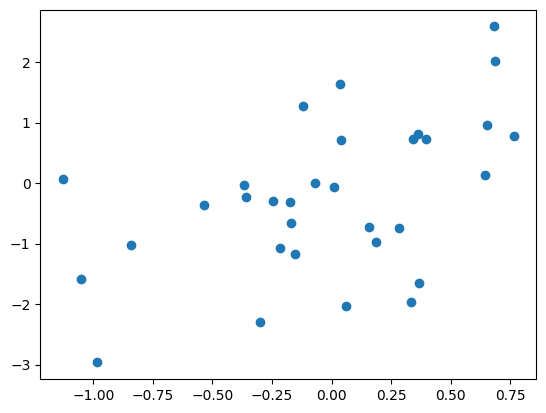

In [12]:
import matplotlib.pyplot as plt

x = digests_rep_output[0].cpu().detach().numpy()
y = digest_inf_input[0][0].cpu().detach().numpy()

plt.scatter(
    x[0],
    y[0]
)
plt.show()